In [51]:
import spacy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import gensim.downloader as api

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
glove = api.load("glove-twitter-25")

In [3]:
glove.similarity(w1="good", w2="great")

0.9378517

In [6]:
glove_good, glove_great = glove["good"], glove["great"]
glove_good.shape, glove_great.shape

((25,), (25,))

In [8]:
fake_df = pd.read_csv("data/RealFakeNews/Fake.csv")
fake_df.head(3)

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"


In [9]:
true_df = pd.read_csv("data/RealFakeNews/True.csv")
true_df.head(3)

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"


In [10]:
fake_df["label"] = "Fake"

In [11]:
fake_df.head(3)

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",Fake
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",Fake
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",Fake


In [13]:
true_df["label"] = "Real"
true_df.head(3)

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",Real
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",Real
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",Real


In [ ]:
data = pd.concat([true_df, fake_df], ignore_index=True)
data = data.sample(frac=1, random_state=42).reset_index(drop=True)


,title,text,subject,date,label
0,BREAKING: GOP Chairman Grassley Has Had Enoug...,"Donald Trump s White House is in chaos, and th...",News,"July 21, 2017",Fake
1,Failed GOP Candidates Remembered In Hilarious...,Now that Donald Trump is the presumptive GOP n...,News,"May 7, 2016",Fake
2,Mike Pence’s New DC Neighbors Are HILARIOUSLY...,Mike Pence is a huge homophobe. He supports ex...,News,"December 3, 2016",Fake


In [15]:
data.head(5)

,title,text,subject,date,label
0,BREAKING: GOP Chairman Grassley Has Had Enoug...,"Donald Trump s White House is in chaos, and th...",News,"July 21, 2017",Fake
1,Failed GOP Candidates Remembered In Hilarious...,Now that Donald Trump is the presumptive GOP n...,News,"May 7, 2016",Fake
2,Mike Pence’s New DC Neighbors Are HILARIOUSLY...,Mike Pence is a huge homophobe. He supports ex...,News,"December 3, 2016",Fake
3,California AG pledges to defend birth control ...,SAN FRANCISCO (Reuters) - California Attorney ...,politicsNews,"October 6, 2017",Real
4,AZ RANCHERS Living On US-Mexico Border Destroy...,Twisted reasoning is all that comes from Pelos...,politics,"Apr 25, 2017",Fake


In [16]:
data.label.value_counts()

label
Fake    23481
Real    21417
Name: count, dtype: int64

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   label    44898 non-null  object
dtypes: object(5)
memory usage: 1.7+ MB


In [18]:
data.isnull().sum()

title      0
text       0
subject    0
date       0
label      0
dtype: int64

In [19]:
data.duplicated().sum()

209

In [21]:
data.drop_duplicates(inplace=True)

In [22]:
data.duplicated().sum()

0

In [23]:
news_df = data.copy()

In [25]:
news_df["label_num"] = news_df["label"].map({"Real": 1, "Fake": 0})
news_df.head(3)

,title,text,subject,date,label,label_num
0,BREAKING: GOP Chairman Grassley Has Had Enoug...,"Donald Trump s White House is in chaos, and th...",News,"July 21, 2017",Fake,0
1,Failed GOP Candidates Remembered In Hilarious...,Now that Donald Trump is the presumptive GOP n...,News,"May 7, 2016",Fake,0
2,Mike Pence’s New DC Neighbors Are HILARIOUSLY...,Mike Pence is a huge homophobe. He supports ex...,News,"December 3, 2016",Fake,0


In [27]:
nlp = spacy.load("en_core_web_lg")

In [28]:
def preprocess_vectorize(text):
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not (token.is_stop or token.is_punct)]

    return glove.get_mean_vector(tokens)

In [31]:
preprocess_vectorize("Don't worry if you don't understand")

array([ 0.07103593,  0.15458359, -0.10960861,  0.05509365, -0.11224825,
       -0.00772668,  0.29390895, -0.08308784, -0.07912375,  0.01270173,
       -0.2084062 ,  0.03991116, -0.8019836 , -0.04794757,  0.01589889,
        0.12052572,  0.04771912, -0.08411238,  0.09999067, -0.1442663 ,
        0.16344635,  0.08888815, -0.04604176,  0.1235037 , -0.1098546 ],
      dtype=float32)

In [32]:
news_df["text_vector"] = news_df["text"].apply(lambda text: preprocess_vectorize(text))

In [35]:
news_df.head(5)

,title,text,subject,date,label,label_num,text_vector
0,BREAKING: GOP Chairman Grassley Has Had Enoug...,"Donald Trump s White House is in chaos, and th...",News,"July 21, 2017",Fake,0,"[-0.0030326557, 0.061606083, -0.080425665, -0...."
1,Failed GOP Candidates Remembered In Hilarious...,Now that Donald Trump is the presumptive GOP n...,News,"May 7, 2016",Fake,0,"[0.004388185, 0.0545114, -0.037923556, -0.0108..."
2,Mike Pence’s New DC Neighbors Are HILARIOUSLY...,Mike Pence is a huge homophobe. He supports ex...,News,"December 3, 2016",Fake,0,"[-0.03603433, 0.055027347, -0.0577395, -0.0212..."
3,California AG pledges to defend birth control ...,SAN FRANCISCO (Reuters) - California Attorney ...,politicsNews,"October 6, 2017",Real,1,"[-0.0010539837, 0.10998381, -0.16318735, -0.01..."
4,AZ RANCHERS Living On US-Mexico Border Destroy...,Twisted reasoning is all that comes from Pelos...,politics,"Apr 25, 2017",Fake,0,"[0.00014034845, 0.081933975, -0.037531618, -0...."


In [34]:
X_train, X_test, y_train, y_test = train_test_split(
    news_df["text_vector"],
    news_df["label_num"],
    test_size= 0.2,
    random_state=42,
    stratify=news_df.label_num
)

In [36]:
X_train.shape, X_test.shape

((35751,), (8938,))

In [37]:
X_train_2d = np.stack(X_train)
X_test_2d = np.stack(X_test)

In [38]:
gradient_boosting_clf = GradientBoostingClassifier()
gradient_boosting_clf.fit(X_train_2d, y_train)

GradientBoostingClassifier()

In [39]:
y_pred = gradient_boosting_clf.predict(X_test_2d)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.86      0.88      0.87      4583
           1       0.87      0.85      0.86      4355

    accuracy                           0.87      8938
   macro avg       0.87      0.87      0.87      8938
weighted avg       0.87      0.87      0.87      8938



In [40]:
test_news = [
    "Michigan governor denies misleading U.S. House on Flint water (Reuters) - Michigan Governor Rick Snyder denied Thursday that he had misled a U.S. House of Representatives committee last year over testimony on Flintâ€™s water crisis after lawmakers asked if his testimony had been contradicted by a witness in a court hearing. The House Oversight and Government Reform Committee wrote Snyder earlier Thursday asking him about published reports that one of his aides, Harvey Hollins, testified in a court hearing last week in Michigan that he had notified Snyder of an outbreak of Legionnairesâ€™ disease linked to the Flint water crisis in December 2015, rather than 2016 as Snyder had testified. â€œMy testimony was truthful and I stand by it,â€ Snyder told the committee in a letter, adding that his office has provided tens of thousands of pages of records to the committee and would continue to cooperate fully.  Last week, prosecutors in Michigan said Dr. Eden Wells, the stateâ€™s chief medical executive who already faced lesser charges, would become the sixth current or former official to face involuntary manslaughter charges in connection with the crisis. The charges stem from more than 80 cases of Legionnairesâ€™ disease and at least 12 deaths that were believed to be linked to the water in Flint after the city switched its source from Lake Huron to the Flint River in April 2014. Wells was among six current and former Michigan and Flint officials charged in June. The other five, including Michigan Health and Human Services Director Nick Lyon, were charged at the time with involuntary manslaughter",
    " WATCH: Fox News Host Loses Her Sh*t, Says Investigating Russia For Hacking Our Election Is Unpatriotic This woman is insane.In an incredibly disrespectful rant against President Obama and anyone else who supports investigating Russian interference in our election, Fox News host Jeanine Pirro said that anybody who is against Donald Trump is anti-American. Look, it s time to take sides,  she began.",
    " Sarah Palin Celebrates After White Man Who Pulled Gun On Black Protesters Goes Unpunished (VIDEO) Sarah Palin, one of the nigh-innumerable  deplorables  in Donald Trump s  basket,  almost outdid herself in terms of horribleness on Friday."
]

test_news_vector = [preprocess_vectorize(text) for text in test_news]
gradient_boosting_clf.predict(test_news_vector)

array([0, 0, 0], dtype=int64)

Text(58.222222222222214, 0.5, 'Truth')

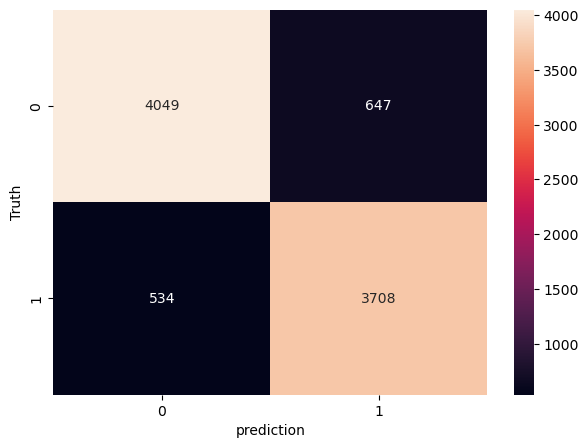

In [42]:
confusion = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(7, 5))
sns.heatmap(confusion, annot=True, fmt="d")
plt.xlabel("prediction")
plt.ylabel("Truth")

In [43]:
randomforest_clf = RandomForestClassifier()
randomforest_clf.fit(X_train_2d, y_train)

RandomForestClassifier()

In [45]:
y_pred = randomforest_clf.predict(X_test_2d)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92      4728
           1       0.91      0.91      0.91      4210

    accuracy                           0.91      8938
   macro avg       0.91      0.91      0.91      8938
weighted avg       0.91      0.91      0.91      8938



In [46]:
test_news = [
    "Michigan governor denies misleading U.S. House on Flint water (Reuters) - Michigan Governor Rick Snyder denied Thursday that he had misled a U.S. House of Representatives committee last year over testimony on Flintâ€™s water crisis after lawmakers asked if his testimony had been contradicted by a witness in a court hearing. The House Oversight and Government Reform Committee wrote Snyder earlier Thursday asking him about published reports that one of his aides, Harvey Hollins, testified in a court hearing last week in Michigan that he had notified Snyder of an outbreak of Legionnairesâ€™ disease linked to the Flint water crisis in December 2015, rather than 2016 as Snyder had testified. â€œMy testimony was truthful and I stand by it,â€ Snyder told the committee in a letter, adding that his office has provided tens of thousands of pages of records to the committee and would continue to cooperate fully.  Last week, prosecutors in Michigan said Dr. Eden Wells, the stateâ€™s chief medical executive who already faced lesser charges, would become the sixth current or former official to face involuntary manslaughter charges in connection with the crisis. The charges stem from more than 80 cases of Legionnairesâ€™ disease and at least 12 deaths that were believed to be linked to the water in Flint after the city switched its source from Lake Huron to the Flint River in April 2014. Wells was among six current and former Michigan and Flint officials charged in June. The other five, including Michigan Health and Human Services Director Nick Lyon, were charged at the time with involuntary manslaughter",
    " WATCH: Fox News Host Loses Her Sh*t, Says Investigating Russia For Hacking Our Election Is Unpatriotic This woman is insane.In an incredibly disrespectful rant against President Obama and anyone else who supports investigating Russian interference in our election, Fox News host Jeanine Pirro said that anybody who is against Donald Trump is anti-American. Look, it s time to take sides,  she began.",
    " Sarah Palin Celebrates After White Man Who Pulled Gun On Black Protesters Goes Unpunished (VIDEO) Sarah Palin, one of the nigh-innumerable  deplorables  in Donald Trump s  basket,  almost outdid herself in terms of horribleness on Friday."
]

test_news_vector = [preprocess_vectorize(text) for text in test_news]
gradient_boosting_clf.predict(test_news_vector)

array([0, 0, 0], dtype=int64)

Text(58.222222222222214, 0.5, 'Truth')

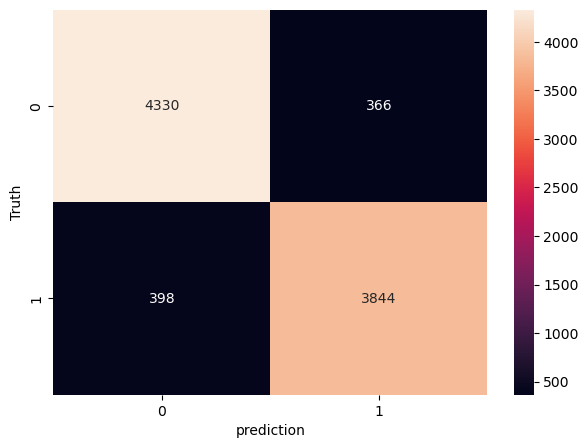

In [47]:
confusion = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(7, 5))
sns.heatmap(confusion, annot=True, fmt="d")
plt.xlabel("prediction")
plt.ylabel("Truth")

In [52]:
naive_bayes_clf = Pipeline([
    ("scaler", MinMaxScaler()),
    ("classifier", MultinomialNB())
])
naive_bayes_clf.fit(X_train_2d, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()), ('classifier', MultinomialNB())])

In [54]:
y_pred = naive_bayes_clf.predict(X_test_2d)
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       1.00      0.53      0.69      8821
           1       0.03      1.00      0.05       117

    accuracy                           0.54      8938
   macro avg       0.51      0.77      0.37      8938
weighted avg       0.99      0.54      0.69      8938



In [55]:
decision_tree_clf = DecisionTreeClassifier()
decision_tree_clf.fit(X_train_2d, y_train)

DecisionTreeClassifier()

In [56]:
y_pred = decision_tree_clf.predict(X_test_2d)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.89      0.87      4696
           1       0.87      0.82      0.85      4242

    accuracy                           0.86      8938
   macro avg       0.86      0.86      0.86      8938
weighted avg       0.86      0.86      0.86      8938

